In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
torch.manual_seed(777)
if device =='cuda':
    torch.cuda.manual_seed_all(777)

cuda


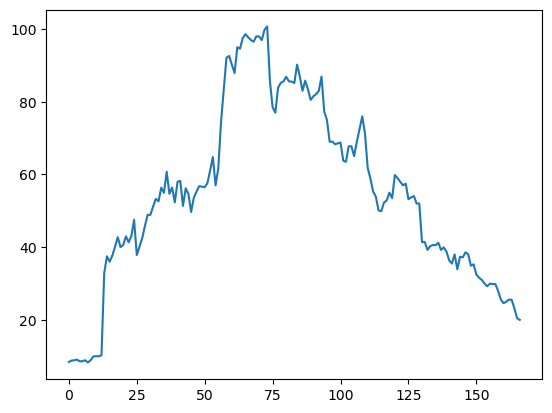

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
 
df = pd.read_csv('./data/AAMC 과거 데이터.csv')[['종가']].values.astype('float32')
 
plt.plot(df)
plt.show()

In [7]:
import torch
 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(np.array(X)), torch.tensor(np.array(y))

In [8]:
lookback = 7
# train-test split for time series
train_size = int(len(df) * 0.67)
test_size = len(df) - train_size
train, test = df[:train_size], df[train_size:]
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([104, 7, 1]) torch.Size([104, 7, 1])
torch.Size([49, 7, 1]) torch.Size([49, 7, 1])


In [9]:
import torch.nn as nn
 
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [25]:
df.squeeze().shape

(167,)

In [31]:
import math
def sigmoid(x):
    return 1/(1+math.exp(-x))

In [ ]:
class Agent:
    def __init__(self, data, model, win_size=7):
        self.data = data
        self.model = model
        self.win_size = win_size
    
    def getState(self, t): # get state in time t (data[time : time+win_size])
        s = t - self.win_size + 1
        return self.data[s:t+1] if s >= 0 else -s*[self.data[0]] + self.data[0:t+1]
    
    def getAction(self, state): # predict next value
        output = self.model(state)
        return output
    
    def getReward(self, state, action): # calc reward where prediction is action
        # define as relative change (y - y_ref) / y_ref
        pass

In [36]:
def getState(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
    # res = []
    # for i in range(n - 1):
    #     res.append(sigmoid((block[i + 1] - block[i])))
    return block
getState(df.squeeze().tolist(), 100, 7)

[77.30000305175781,
 74.98999786376953,
 69.0,
 69.05000305175781,
 68.30000305175781,
 68.55999755859375,
 68.77999877929688]

In [ ]:
class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        self.state_size = state_size # normalized previous days
        self.action_size = 3 # sit, buy, sell
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.model = load_model(model_name) if is_eval else self._model()
    def _model(self):
        model = Sequential()
        model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        model.add(Dense(units=32, activation="relu"))
        model.add(Dense(units=8, activation="relu"))
        model.add(Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=Adam(lr=0.001))
        return model
    def act(self, state):
        if not self.is_eval and random.random()<= self.epsilon:
            return random.randrange(self.action_size)
        options = self.model.predict(state)
        return np.argmax(options[0])
    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])
        for state, action, reward, next_state, done in mini_batch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay